In [1]:
from matplotlib.pyplot import imshow
from pathlib import Path
from tqdm import tqdm
import numpy as np
from os import scandir, walk, remove
import pandas as pd
from fastprogress import progress_bar
from fastai import *
from fastai.vision import *
from PIL import Image
from numbers import Integral

# Dropout on Image

In [2]:
data_path = 'lbl_data_resized/'

In [3]:
trn_val = pd.read_csv("train_test_split_clean.csv")
trn_val_dict = {row.fname: row.is_val_set for _, row in trn_val.iterrows()}

In [4]:
def get_split(fname):
      return trn_val_dict[fname.name]

In [5]:
import re
pat = '^rice_'

def is_rice(fname):
    if re.search(pat,fname.stem): return True
    return False

In [6]:
src = (ImageList.from_folder(Path(data_path))
        .split_by_valid_func(get_split)
        .label_from_func(is_rice)
      )
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
data = (src.transform(tfms,size=224)
        .databunch(bs=40)
        .normalize(imagenet_stats)
       )

In [7]:
def f1_score(y_pred:Tensor, y_true:Tensor,beta:float=1, eps:float=1e-9)->Rank0Tensor:
    "Computes the f_beta between `preds` and `targets`"
    beta2 = beta ** 2

    y_pred = y_pred.argmax(dim=1).float()
    y_true = y_true.float()
    
    TP = (y_pred*y_true).sum()
    prec = TP/(y_pred.sum()+eps)
    rec = TP/(y_true.sum()+eps)
    res = (prec*rec)/(prec*beta2+rec+eps)*(1+beta2)
    return res.mean()

In [8]:
model = nn.Sequential(nn.Dropout(0.2), create_cnn_model(models.resnet34, nc=2))
learner = Learner(data, model, metrics=[accuracy, f1_score])

In [9]:
def _nts_split(m):
    groups = [[*list(m.children())[:1]]]
    groups += [[*list(m.children())[1:]]]
    return groups

In [11]:
learner.split(_nts_split);

In [11]:
learner.freeze()

In [12]:
learner.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.683078,0.687369,0.578143,0.524105,00:39
1,0.684062,0.701128,0.580436,0.413207,00:39
2,0.661358,0.717924,0.570501,0.440093,00:39
3,0.649524,0.673054,0.590753,0.455888,00:39


In [13]:
learner.save('image-droput_0.2')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-04
Min loss divided by 10: 6.31E-08


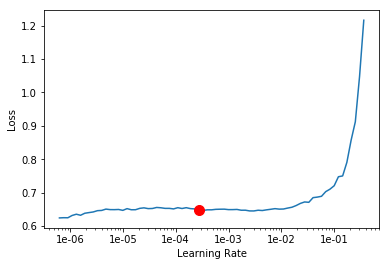

In [15]:
learner.unfreeze()
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [16]:
learner.fit_one_cycle(4, slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.645563,0.660787,0.598777,0.445759,00:38
1,0.634303,0.729609,0.589224,0.546895,00:37
2,0.623284,0.675052,0.593810,0.516461,00:38
3,0.621407,0.660425,0.612151,0.544587,00:38


In [17]:
learner.save('image_droput_0.2-2')

In [20]:
learner.load('image_droput_0.2-2');

In [21]:
# Scores were improving. Train a bit more
learner.fit_one_cycle(6, slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.631383,0.681120,0.609859,0.579265,00:38
1,0.632765,0.659604,0.581964,0.554637,00:37
2,0.632130,0.688509,0.589989,0.550862,00:38
3,0.610720,0.770059,0.583493,0.583443,00:37
4,0.619057,0.705288,0.585785,0.579841,00:37
5,0.611399,0.690553,0.583875,0.586934,00:39


In [22]:
learner.save('image_droput_0.2-3')

In [24]:
learner.load('image_droput_0.2-3');

In [25]:
# Train using lower learning rates
learner.fit_one_cycle(10, slice(5e-6, 5e-5))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.603543,0.735981,0.585403,0.605008,00:39
1,0.607093,0.729028,0.598013,0.618346,00:38
2,0.604410,0.687192,0.598777,0.625416,00:37
3,0.600242,0.721448,0.602216,0.647527,00:37
4,0.607323,0.802122,0.575850,0.621974,00:39
5,0.603341,0.748991,0.589606,0.610508,00:39
6,0.603717,0.754423,0.589224,0.615865,00:39
7,0.595060,0.769995,0.576614,0.613357,00:39
8,0.597425,0.743454,0.582346,0.614185,00:39
9,0.590876,0.743392,0.577761,0.619770,00:39


In [26]:
learner.save('image_droput_0.2-4')

In [27]:
learner.load('image_droput_0.2-4');

In [30]:
# Increse the dropout strength
learner.model[0].p = 0.25

In [33]:
learner.model[0]

Dropout(p=0.25)

In [34]:
learner.fit_one_cycle(10, slice(1e-6, 1e-5))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.597408,0.812062,0.563240,0.618545,00:39
1,0.596366,0.819172,0.568972,0.621739,00:39
2,0.601624,0.798062,0.565533,0.617951,00:39
3,0.597805,0.864862,0.566297,0.622306,00:39
4,0.589755,0.849975,0.568590,0.618143,00:39
5,0.601963,0.872138,0.566297,0.618377,00:39
6,0.588781,0.867691,0.556744,0.617348,00:39
7,0.594336,0.877333,0.564005,0.619171,00:39
8,0.590715,0.861238,0.562094,0.619145,00:39
9,0.600145,0.870173,0.560183,0.618381,00:38


In [44]:
learner.save('image_droput_0.25-1')

In [47]:
learner.load('image_droput_0.25-1');

In [48]:
# Why is model training taking so low time compared to James' notebook?
# Are the layers frozen?
learner.unfreeze()

In [49]:
learner.fit_one_cycle(10, slice(9e-7, 9e-6))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.589401,0.894505,0.561330,0.618494,00:39
1,0.582241,0.858340,0.560566,0.618859,00:39
2,0.600463,0.894775,0.557126,0.639166,00:39
3,0.578010,0.906875,0.557891,0.638914,00:40
4,0.585490,0.803184,0.565915,0.639888,00:39
5,0.591104,0.871344,0.562094,0.639658,00:39
6,0.586534,0.896972,0.558655,0.638400,00:39
7,0.584361,0.885737,0.562094,0.636041,00:39
8,0.579231,0.958360,0.559419,0.640783,00:39
9,0.584954,0.892166,0.560566,0.635514,00:39


In [50]:
learner.save('image_droput_0.25-2')

In [51]:
learner.load('image_droput_0.25-2');

In [52]:
learner.fit_one_cycle(15, slice(5e-7, 5e-6))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.582103,0.866903,0.563622,0.637398,00:38
1,0.579852,0.873282,0.560948,0.634211,00:38
2,0.589750,0.882855,0.565151,0.637376,00:39
3,0.593678,0.882451,0.552541,0.615914,00:39
4,0.583781,0.892826,0.559037,0.621364,00:39
5,0.586725,0.862940,0.563622,0.636794,00:39
6,0.585619,0.834170,0.557509,0.615605,00:39
7,0.584336,0.854507,0.556744,0.614719,00:39
8,0.587274,0.861329,0.558273,0.617872,00:38
9,0.590512,0.892578,0.559037,0.635838,00:37


In [53]:
learner.save('image_droput_0.25-3')

In [13]:
learner.load('image_droput_0.25-3');